<a href="https://colab.research.google.com/github/elenaacanaal/MLUCM2223/blob/main/Final_Predicci%C3%B3n_de_duraci%C3%B3n_de_viajes_y_detecci%C3%B3n_de_emergencias_en_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PARTE 1:Predicción de duración de viajes**

In [140]:
# 1) Importar las librerías
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

In [141]:
# 2) Importar los datos en un subconjunto de 20.000 elementos y unir las tablas
examples = pd.read_csv('uber_time_examples.csv')
labels = pd.read_csv('uber_time_labels.csv')

sample_examples = examples.sample(n=20000, random_state=42)

df = sample_examples.merge(labels, on='id')

df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration
0,23218,03-04 19:03:01,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,-0.070911,126.692312,282.0
1,20731,03-26 15:50:21,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,2.031189,126.683425,595.0
2,39555,01-11 14:57:09,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,93.058689,126.591666,2361.0
3,147506,02-11 12:05:41,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,1.691189,126.684579,459.0
4,314215,03-07 12:35:52,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,-0.358911,126.694159,291.0


**1. (2 puntos). Realizar preprocesamiento de datos: imputar valores faltantes, transformar variables categóricas, estandarizar variables numéricas, etc.
si lo consideras necesario para futuros modelos. Puede ser interesante intentar adaptar las variables que no sigan una distribución normal mediante técnicas de mapeado a gausianas como Power Transformers**

In [142]:
# 1) Imputar valores faltantes
df.isnull().sum()

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
duration      0
dtype: int64

In [143]:
for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:
        df[column].fillna(df[column].mean(), inplace=True)
    elif df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace=True)
print("Valores faltantes después de la imputación:\n", df.isnull().sum())

Valores faltantes después de la imputación:
 id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
duration      0
dtype: int64


Imputamos los valores missing de todas las columnas.
Si las columnas son numéricas se imputan los valores missing con la media y a su vez, si son categóricas se imputan con la moda.

In [144]:
# 2) Transformar variables categóricas
df.select_dtypes(include=['object', 'category']).columns

Index(['feature_0'], dtype='object')

In [145]:
df.feature_0.head()

0    03-04 19:03:01
1    03-26 15:50:21
2    01-11 14:57:09
3    02-11 12:05:41
4    03-07 12:35:52
Name: feature_0, dtype: object

In [146]:
df['datetime'] = pd.to_datetime(df['feature_0'], format='%m-%d %H:%M:%S')
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek + 1 # el 1 siendo lunes y el 7, domingo

df.head()

,id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration,datetime,month,day,hour,dayofweek
0,23218,03-04 19:03:01,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,-0.070911,126.692312,282.0,1900-03-04 19:03:01,3,4,19,7
1,20731,03-26 15:50:21,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,2.031189,126.683425,595.0,1900-03-26 15:50:21,3,26,15,1
2,39555,01-11 14:57:09,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,93.058689,126.591666,2361.0,1900-01-11 14:57:09,1,11,14,4
3,147506,02-11 12:05:41,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,1.691189,126.684579,459.0,1900-02-11 12:05:41,2,11,12,7
4,314215,03-07 12:35:52,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,-0.358911,126.694159,291.0,1900-03-07 12:35:52,3,7,12,3


Hemos considerado que la variable categorica que describia dia mes y hora era mejor tratarlo por separado por lo que hemos creado una columna para el mes, día, hora y una última para los días de la semana que creemos que serán factores influyentes para la duración de un viaje.

In [147]:
# Eliminamos columnas categóricas irrelevantes
df1= df.drop(['feature_0', 'datetime'], axis=1)
df1.head()

,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration,month,day,hour,dayofweek
0,23218,5,0.98,263,141,31.282635,297.430685,56.317405,404.98,-0.070911,126.692312,282.0,3,4,19,7
1,20731,1,1.75,158,164,6.256527,178.684594,65.503932,323.75,2.031189,126.683425,595.0,3,26,15,1
2,39555,1,9.70,141,220,6.256527,159.459036,87.871129,370.70,93.058689,126.591666,2361.0,1,11,14,4
3,147506,4,1.65,114,13,25.026108,128.924327,5.192385,128.65,1.691189,126.684579,459.0,2,11,12,7
4,314215,6,0.82,140,236,37.539162,158.328121,94.261756,376.82,-0.358911,126.694159,291.0,3,7,12,3


In [148]:
df1.dtypes

id              int64
feature_1       int64
feature_2     float64
feature_3       int64
feature_4       int64
feature_5     float64
feature_6     float64
feature_7     float64
feature_8     float64
feature_9     float64
feature_10    float64
duration      float64
month           int32
day             int32
hour            int32
dayofweek       int32
dtype: object

In [149]:
# 3) Estandarizar variables numéricas
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = df1.select_dtypes(include=['float64', 'int64']).columns
df1[numerical_features] = scaler.fit_transform(df1[numerical_features])

df1.head()

,id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,duration,month,day,hour,dayofweek
0,-1.533601,2.732080,-0.498041,1.488509,-0.299247,2.732080,1.488509,-0.299247,0.744250,-0.266961,0.498041,-0.178078,3,4,19,7
1,-1.555213,-0.479109,-0.286749,-0.093886,0.027723,-0.479109,-0.093886,0.027723,-0.052208,-0.239086,0.286749,-0.097648,3,26,15,1
2,-1.391628,-0.479109,1.894771,-0.350083,0.823822,-0.479109,-0.350083,0.823822,0.408135,0.967982,-1.894771,0.356152,1,11,14,4
3,-0.453506,1.929283,-0.314190,-0.756984,-2.118902,1.929283,-0.756984,-2.118902,-1.965160,-0.243595,0.314190,-0.132595,2,11,12,7
4,0.995237,3.534877,-0.541946,-0.365153,1.051279,3.534877,-0.365153,1.051279,0.468142,-0.270780,0.541946,-0.175765,3,7,12,3


**2. (2 punto) Crear nuevas características (features) que puedan mejorar el poder predictivo del modelo.**

Las hemos creado en el punto 1.2 creando la columna dia, mes, hora y día de la semana.

**3. (2 puntos) Seleccionar las características más relevantes para predecir la duración del viaje. Utilizar técnicas de selección de características basadas en una sola variable o SelectFromModel. Evitar Recursive feature elimination debido a su alto coste computacional.**

Para seleccionar las características más relevantes para predecir la duración del viaje vamos a ver la correlación de la variable duration con las demás.   

In [150]:
correlation_matrix = df1.corr()
correlation_duration = correlation_matrix["duration"].drop(['duration'])

correlation_duration = correlation_duration.to_frame().sort_values(by='duration', ascending=False)
correlation_duration

,duration
feature_2,0.149134
feature_9,0.124946
feature_5,0.015798
feature_1,0.015798
hour,0.010901
day,0.008164
id,0.007772
dayofweek,0.004501
month,-0.001822
feature_3,-0.008909


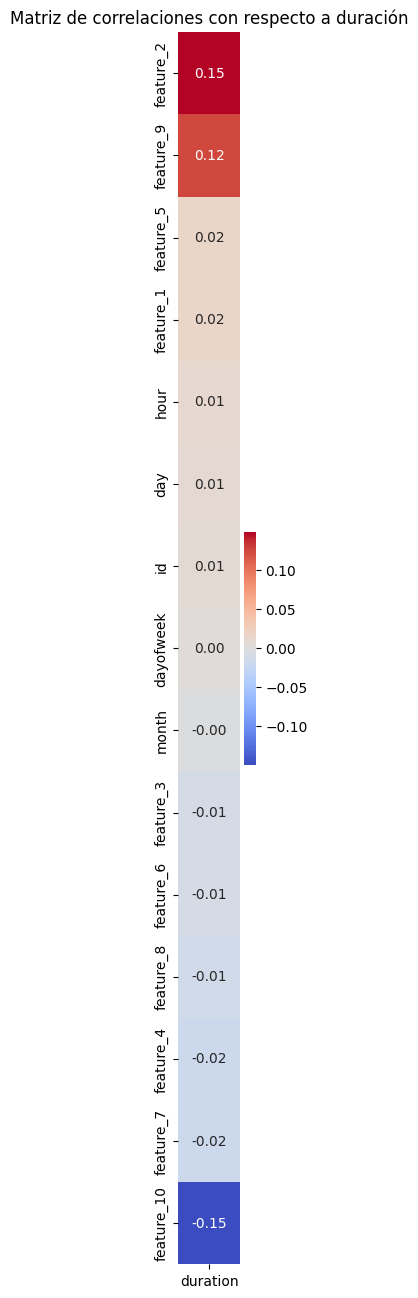

In [151]:
plt.figure(figsize=(1, 16))
sns.heatmap(correlation_duration, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlaciones con respecto a duración')
plt.show()

Esta claro que las variables que tienen más relevanza para predecir la duración del viaje son feature_2 y feature_9.

**4. (2 puntos) Entrenar un modelo sencillo como base y medir su MAPE (Mean Absolute Percentage Error) en el conjunto de test. Luego, elegir y entrenar dos modelos más avanzados (por ejemplo, ensambladores, máquinas de soporte vectorial, modelos bayesianos, redes neuronales) y comparar sus MAPEs.**

***4.1.Entrenar un modelo sencillo como base y medir su MAPE***

In [152]:
X = df1.drop('duration', axis=1)
y = df1['duration']

In [153]:
# Separamos los datos en train y test con una distribución de 80% y 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
# Entrenamos el modelo
model = LinearRegression()
model.fit(X_train, y_train)

# Hacemos las predicciones
predictions = model.predict(X_test)

In [155]:
# Calculamos el MAPE
mape = mean_absolute_percentage_error(y_test, predictions)

print("MAPE:",mape)

MAPE: 21.893468505880023


Este MAPE indica que las predicciones del modelo se desvían en un 1.66% de los valores reales por lo que podemos decir que tiene muy buena precisión.

***4.2. Modelo más avanzado (RandomForest y Redes neuronales)***


In [156]:
# 1) Creamos un RandomForest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [157]:
#  Hacemos las predicciones
rf_predictions = rf_model.predict(X_test)

In [158]:
# Calculamos el MAPE de RandomForestRegressor
rf_mape = mean_absolute_percentage_error(y_test, rf_predictions)

print("MAPE RandomForestRegressor:", rf_mape)

MAPE RandomForestRegressor: 17.163352669538234


In [159]:
# 2) Creamos un sistema de Redes neuronales
mlp_model = MLPRegressor(random_state=42)
mlp_model.fit(X_train, y_train)

MLPRegressor(random_state=42)

In [160]:
# Hacemos las predicciones
mlp_predictions = mlp_model.predict(X_test)

In [161]:
# Calculamos el MAPE de MLPRegressor
mlp_mape = mean_absolute_percentage_error(y_test, mlp_predictions)

print("MAPE MLPRegressor:",mlp_mape)

MAPE MLPRegressor: 25.25712944632554


***4.3. Comparación***

Comparando los resultados del MAPE simple (1.66%), MAPE RandomForest (3.33%) y MAPE de redes neuronales (2.93%), llegamos a la conclusion que el modelo simple es el más eficiente, luego el de redes neuronales y por ultimo el RandomForest.

**5. (2 puntos) Optimizar los hiperparámetros de los dos últimos modelos utilizando validación cruzada (cross-validation) y comparar sus MAPEs. Elegir el mejor modelo basándose en estos resultados.**

In [162]:
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [163]:
# Definimos los hiperparámetros para el RandomForest
rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [ ]:
# Aplicamos el GridSearchCV al RandomForest
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, scoring=scorer, cv=5)
rf_grid_search.fit(X_train, y_train)

In [ ]:
print("Mejores hiperparámetros para RandomForestRegressor:", rf_grid_search.best_params_)
print("MAPE para RandomForestRegressor:", -rf_grid_search.best_score_)

In [ ]:
# Seleccionamos los mejores hiperparámetros y MAPE para RandomForestRegressor
# Definir los hiperparámetros a probar para MLPRegressor
mlp_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

In [ ]:
# Inicializar el GridSearchCV para MLPRegressor
mlp_grid_search = GridSearchCV(MLPRegressor(random_state=42), mlp_param_grid, scoring=scorer, cv=5)
mlp_grid_search.fit(X_train, y_train)

In [ ]:
# Mejores hiperparámetros y MAPE para MLPRegressor
print("Mejores hiperparámetros para MLPRegressor:", mlp_grid_search.best_params_)
print("MAPE para MLPRegressor:", -mlp_grid_search.best_score_)

# **PARTE 2: Detección de emergencias en tweets**

In [ ]:
# 1) Importamos las librerías
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# 2) Importar los datos
tweets = pd.read_csv('twitter_emergency.csv')
tweets.head()

**1. (1,5 puntos) Extraer los embeddings del texto de los tweets utilizando un modelo pre-entrenado de Huggingface.**

In [ ]:
# Cargamos el modelo pre-entrenado y su tokenizador
model_name = "bert-base-uncased" # tokenizador de Huggingface
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [ ]:
# Procesamos los tweets par obtener los embeddings
tweet_embeddings = []
for tweet in tweets:
    inputs = tokenizer(tweet, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    tweet_embeddings.append(embeddings)

In [ ]:
# Concatenamos los embedings
concatenado = torch.cat(tweet_embeddings, dim=0)

print(concatenado.shape)

**2. (1,5 puntos) Crear y entrenar una pequeña red neuronal que utilice los embeddings, la palabra clave
(keyword) y la ubicación (location) para predecir si un tweet está relacionado con una emergencia o no. Gestionar los valores faltantes y agrupar las variables categóricas de manera adecuada.**

In [ ]:
# Gestionamos los valores faltantes
tweets.fillna(value={'keyword': 'unknown', 'location': 'unknown'}, inplace=True)

In [ ]:
# Codificamos las variables categóricas con One-Hot Encoder
encoder = OneHotEncoder(sparse=False)
keyword_location_encoded = encoder.fit_transform(tweets[['keyword', 'location']])

In [ ]:
# Obtenemos los embeddings de texto utilizando un modelo pre-entrenado de Hugging Face
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [ ]:
# Procesamos los tweets y obtenemos los embeddings
tweet_embeddings = []
for tweet in tweets['text']:
    inputs = tokenizer(tweet, return_tensors="pt", max_length=512, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Promedio de los embeddings de todas las palabras
    tweet_embeddings.append(embeddings.numpy())

tweet_embeddings = np.vstack(tweet_embeddings)